## Import Libraries 

In [1]:
import warnings
import sys
sys.path.insert(0, '../../src')
warnings.filterwarnings('ignore')

In [2]:
import ABC_train_test
import californiaDataset
import network
import dataset
import sanityChecks
import performanceMetrics
import torch 
import numpy as np 
from torch.utils.data import random_split 
import scrapbook as sb
from statistics import mean 
import statsModel
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.model_selection import train_test_split

## Parameters
ABC-Generator parameters are as mentioned below: 
1. mean : 1 ($\beta \sim N(\beta^{*},\sigma)$ where $\beta^{*}$ are coefficients of statistical model) or 1 ($\beta \sim N(0,\sigma)$
2. std : $\sigma = 1, 0.1 , 0.01$ (standard deviation)

In [3]:
#ABC Generator Parameters
abc_mean = 1
variance = 1
bias = 1 
#Training parameters 
n_epochs = 500

In [4]:
# Parameters
variance = 1
bias = 0


## Dataset

In [5]:
#Parameters 
n_features = 8
n_samples= 20640
n_target = 1 

In [6]:
X, Y = californiaDataset.california_data()
# Train test split for dataset 
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size = 0.2)
train_data = dataset.CustomDataset(X_train,Y_train)
test_data = dataset.CustomDataset(X_test,Y_test)

       X1    X2        X3        X4      X5        X6     X7      X8      Y
0  8.3252  41.0  6.984127  1.023810   322.0  2.555556  37.88 -122.23  4.526
1  8.3014  21.0  6.238137  0.971880  2401.0  2.109842  37.86 -122.22  3.585
2  7.2574  52.0  8.288136  1.073446   496.0  2.802260  37.85 -122.24  3.521
3  5.6431  52.0  5.817352  1.073059   558.0  2.547945  37.85 -122.25  3.413
4  3.8462  52.0  6.281853  1.081081   565.0  2.181467  37.85 -122.25  3.422


## Training Parameters 



In [7]:
batch_size = 256
#Select the device 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### MSE Threshold and Mean Coeff Values 

Fetch coefficient values from stats model to be used in the ABC pre-generator 

Fetch MSE threshold for training the ABC-GAN 

The ABC-GAN will be trained until the threshold MSE is achieved or until it completes 5000 epochs 

The threshold mse is the mean mse of Catboost over 10 runs

No handles with labels found to put in legend.


                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.607
Model:                            OLS   Adj. R-squared (uncentered):              0.607
Method:                 Least Squares   F-statistic:                              3191.
Date:                Tue, 26 Jul 2022   Prob (F-statistic):                        0.00
Time:                        15:08:02   Log-Likelihood:                         -15684.
No. Observations:               16512   AIC:                                  3.138e+04
Df Residuals:                   16504   BIC:                                  3.145e+04
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

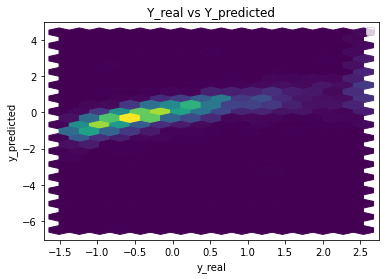

Performance Metrics
Mean Squared Error: 0.4122486707820031
Mean Absolute Error: 0.46542768195451806
Manhattan distance: 1921.2854711082523
Euclidean distance: 41.252424328614985


Prior Model MAE 0.46542768195451806


ABC Pre-generator MAE 0.941841848081568


In [8]:
coeff , y_pred =statsModel.statsModel(X_train,Y_train,X_test,Y_test)
y_abc = y_pred + np.random.normal(0,variance, y_pred.shape) + bias 
mse = mean_squared_error(y_pred,Y_test)
sb.glue("Prior Model MSE",mse)
mse = mean_squared_error(y_abc,Y_test)
sb.glue("ABC Pre-generator MSE",mse)

mae = mean_absolute_error(y_pred,Y_test)
sb.glue("Prior Model MSE",mae)
print("Prior Model MAE",mae)
mae = mean_absolute_error(y_abc,Y_test)
sb.glue("ABC Pre-generator MSE",mae)
print("ABC Pre-generator MAE",mae)

# mGAN 

In [9]:
gen = network.Generator(n_features+1).to(device)
disc = network.Discriminator(n_features+1).to(device)

criterion = torch.nn.BCELoss()
gen_opt = torch.optim.Adam(gen.parameters(), lr=0.01, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(disc.parameters(), lr=0.01, betas=(0.5, 0.999))

In [10]:
#Training the ABC_GAN 
discLossA1,genLossA1 = ABC_train_test.training_GAN(disc, gen,disc_opt,gen_opt,train_data,batch_size,n_epochs,criterion,coeff,abc_mean,variance,bias,device)
sb.glue("ABC_GAN_1 Generator Loss",genLossA1)
sb.glue("ABC_GAN_1 Discriminator Loss",discLossA1)

In [11]:
ABC_GAN1_metrics=ABC_train_test.test_generator(gen,test_data,coeff,abc_mean,variance,bias,device)
sb.glue("ABC_GAN_1 Metrics",ABC_GAN1_metrics)
print('MAE:', mean(ABC_GAN1_metrics[1]))

MAE: 0.4492867707110442


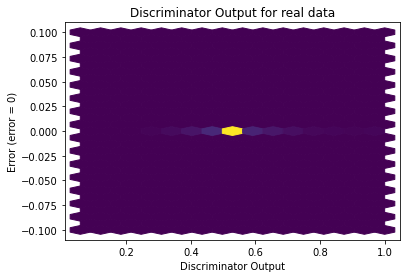

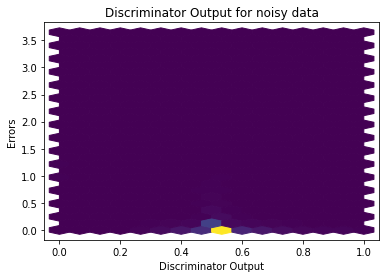

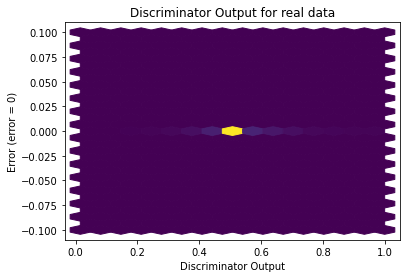

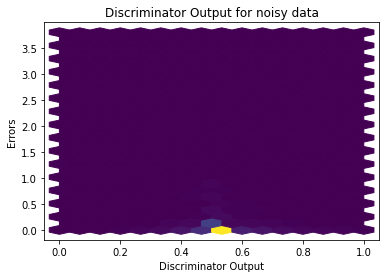

In [12]:
sanityChecks.discProbVsError(train_data,disc,device)
sanityChecks.discProbVsError(test_data,disc,device)

# mGAN Tabnet Generator

In [13]:
gen2 = network.GeneratorTabnet(n_features+1).to(device)
disc2 = network.Discriminator(n_features+1).to(device)

criterion = torch.nn.BCELoss()
gen_opt = torch.optim.Adam(gen2.parameters(), lr=0.01, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(disc2.parameters(), lr=0.01, betas=(0.5, 0.999))

In [14]:
#Training the ABC_GAN 
discLossA2,genLossA2 = ABC_train_test.training_GAN(disc2, gen2,disc_opt,gen_opt,train_data,batch_size,n_epochs,criterion,coeff,abc_mean,variance,bias,device)
sb.glue("ABC_GAN_2 Generator Loss",genLossA2)
sb.glue("ABC_GAN_2 Discriminator Loss",discLossA2)

In [15]:
ABC_GAN2_metrics=ABC_train_test.test_generator(gen2,test_data,coeff,abc_mean,variance,bias,device)
sb.glue("ABC_GAN_2 Metrics",ABC_GAN2_metrics)
print('MAE:', mean(ABC_GAN2_metrics[1]))

MAE: 0.49032310708208243


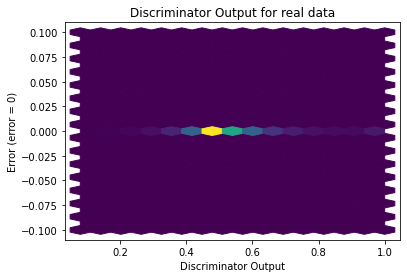

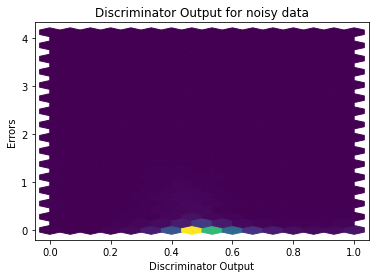

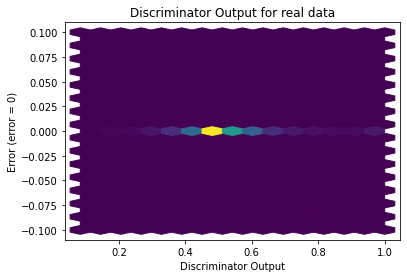

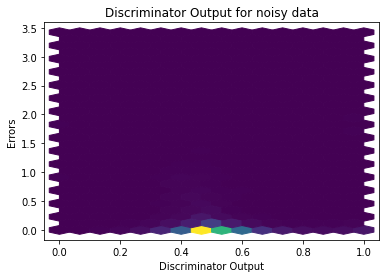

In [16]:
sanityChecks.discProbVsError(train_data,disc2,device)
sanityChecks.discProbVsError(test_data,disc2,device)

# skip-GAN

In [17]:
#Generator
gen3 = network.GeneratorWithSkipConnection(n_features+1).to(device)
#Discriminator 
disc3 = network.Discriminator(n_features+1).to(device)

criterion = torch.nn.BCELoss()
gen_opt = torch.optim.Adam(gen3.parameters(), lr=0.01, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(disc3.parameters(), lr=0.01, betas=(0.5, 0.999))


In [18]:
discLossA3,genLossA3 = ABC_train_test.training_GAN_skip_connection(disc3, gen3,disc_opt,gen_opt,train_data,batch_size, n_epochs,criterion,coeff,abc_mean,variance,bias,device)

sb.glue("ABC_GAN_3 Generator Loss",genLossA3)
sb.glue("ABC_GAN_3 Discriminator Loss",discLossA3)

In [19]:
ABC_GAN3_metrics=ABC_train_test.test_generator(gen3,test_data,coeff,abc_mean,variance,bias,device)

sb.glue("ABC_GAN_3 Metrics",ABC_GAN3_metrics)
print("MAE:", mean(ABC_GAN3_metrics[1]))

MAE: 0.4571347662853599


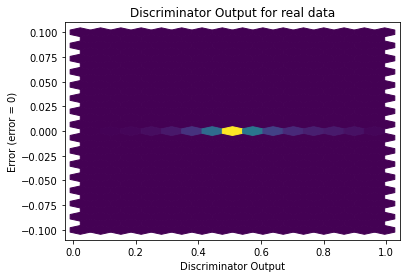

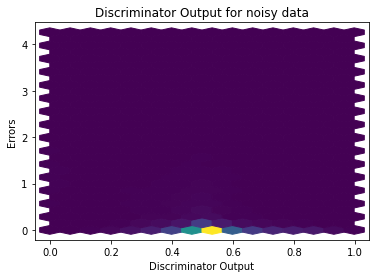

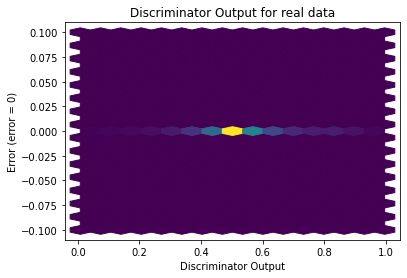

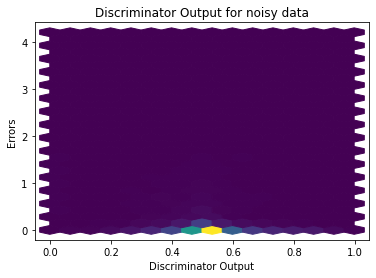

In [20]:
sanityChecks.discProbVsError(train_data,disc3,device)
sanityChecks.discProbVsError(test_data,disc3,device)

# skip-GAN TabNet generator

In [21]:
#Generator
gen4 = network.GeneratorTabnetskipConnection(n_features+1).to(device)
#Discriminator 
disc4 = network.Discriminator(n_features+1).to(device)

criterion = torch.nn.BCELoss()
gen_opt = torch.optim.Adam(gen4.parameters(), lr=0.01, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(disc4.parameters(), lr=0.01, betas=(0.5, 0.999))


In [22]:
discLossA4,genLossA4 = ABC_train_test.training_GAN_skip_connection(disc4, gen4,disc_opt,gen_opt,train_data,batch_size, n_epochs,criterion,coeff,abc_mean,variance,bias,device)

sb.glue("ABC_GAN_4 Generator Loss",genLossA4)
sb.glue("ABC_GAN_4 Discriminator Loss",discLossA4)

In [23]:
ABC_GAN4_metrics=ABC_train_test.test_generator(gen4,test_data,coeff,abc_mean,variance,bias,device)

sb.glue("ABC_GAN_4 Metrics",ABC_GAN4_metrics)
print("MAE:", mean(ABC_GAN4_metrics[1]))

MAE: 0.4452823760959734


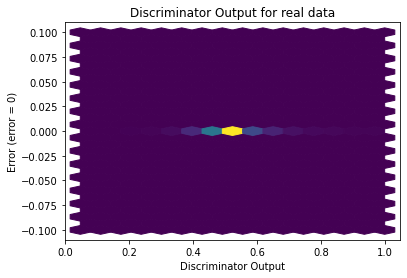

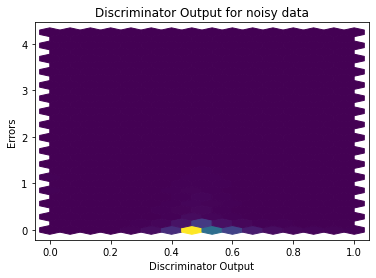

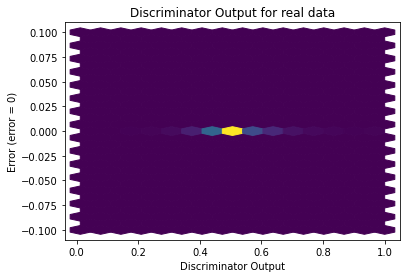

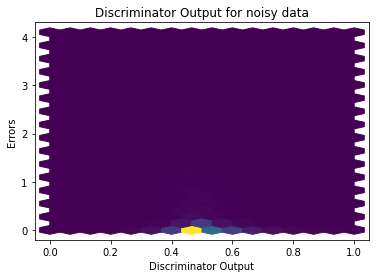

In [24]:
sanityChecks.discProbVsError(train_data,disc4,device)
sanityChecks.discProbVsError(test_data,disc4,device)

## Skip Connection Model Analysis - skipGAN

### Weight Analysis 

Study the weights of the skip connection layer

Equation of the skip connection is 

$output = y_{gan} * w + y_{abc} * (1-w)$

In [25]:
print("Weight of the node at skip connection")
for name,param in gen3.named_parameters():
    if(name == "skipNode.weight"):
        print(param)
        sb.glue("Skip Connection Weight",param.item())
        print("Skip Connection Weight",param.item())

Weight of the node at skip connection
Parameter containing:
tensor([[0.9828]], requires_grad=True)


Skip Connection Weight 0.9828378558158875


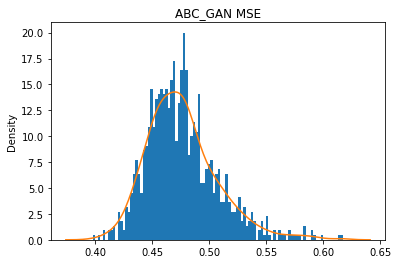

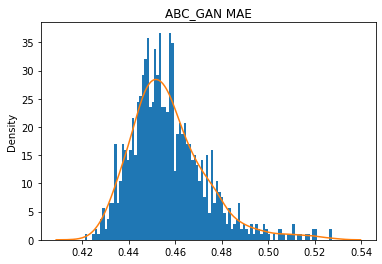

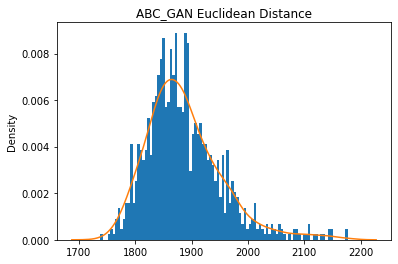

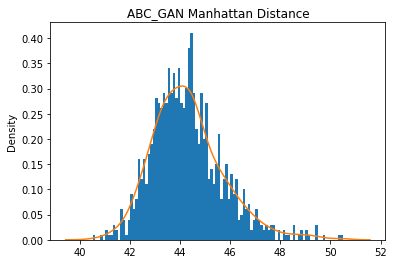

In [26]:
performanceMetrics.modelAnalysis2(ABC_GAN3_metrics)

## Skip Connection Model Analysis - skipGAN (TabNet Generator)

### Weight Analysis 

Study the weights of the skip connection layer

Equation of the skip connection is 

$output = y_{gan} * w + y_{abc} * (1-w)$

In [27]:
print("Weight of the node at skip connection")
for name,param in gen4.named_parameters():
    if(name == "skipNode.weight"):
        print(param)
        sb.glue("Skip Connection Weight",param.item())
        print("Skip Connection Weight",param.item())

Weight of the node at skip connection
Parameter containing:
tensor([[0.9880]], requires_grad=True)


Skip Connection Weight 0.9880011081695557


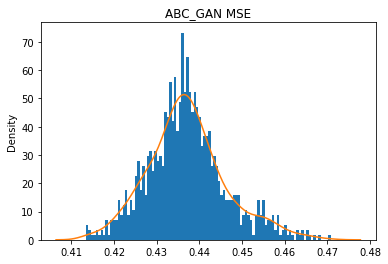

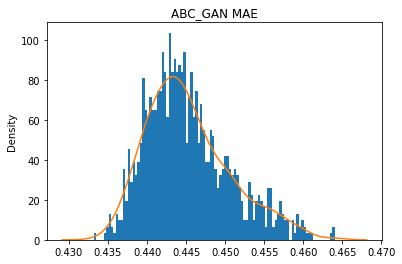

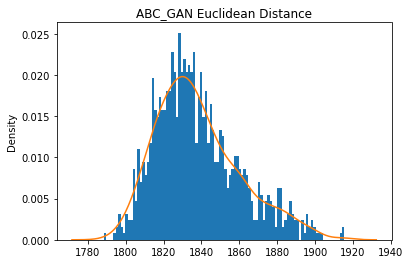

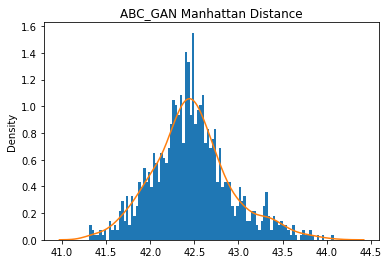

In [28]:
performanceMetrics.modelAnalysis2(ABC_GAN4_metrics)